Final Project Submission

Student name: Deon Durrant

Student pace: self paced

Scheduled project review date/time:

Instructor name: Mark Bardour

Business and Data Understanding

The King Isle event coordinator is responsible for organizing and recommending movie screenings for the residents of the island. The coordinator's goal is to ensure that each resident is offered movies they are more inclined to watch and enjoy based on their previous movie preferences. King Isle’s movie recommendation system should be able to provide tailored movie suggestions for each resident, allowing them to have a more enjoyable viewing experience.

Problem Statement:
The event coordinator needs to provide top 5 personalized movie recommendations to each resident based on their previous movie ratings. By analyzing the historical ratings given by residents to other movies, the system should predict which movies each resident would likely enjoy in the future and prioritize the highest-rated ones.

# Summary 
A movie recommendation system was developed to address the business problem using the MovieLens dataset, which contains 610 users and 100,836 movies and ratings. Initial data exploration revealed a positive bias in ratings and data sparsity due to low user engagement. To tackle these issues, a model-based collaborative filtering approach using Spark’s MLlib was employed. Matrix factorization via Alternating Least Squares (ALS) was used to manage the sparse data and the impact of extreme rating. A baseline model was tested with explicit feedback, and a cold-start strategy defined to handle null predictions. Hyperparameter tuning was conducted using Spark's machine learning pipeline, leveraging ParamGridBuilder and CrossValidator to optimize model performance. Root Mean Square Error (RMSE) was the primary accuracy metric for model evaluation, with the final model achieving an RMSE of 0.8769 compared to the baseline of 0.8813.

The recommendation system was developed and assessed using both RMSE and Precision@K, which measures the proportion of relevant recommended items in the top-K. For example, the top five recommended movies had an RMSE of 0.456, while the Average Precision@K with a 4.5 relevance threshold was 0.6827. The proof of concept included recommendations to a distinct set of users and movies, demonstrating the system’s effectiveness. Personalized recommendations for individual user were also generated to gain deeper insights. While the goal was to identify the highest-rated movies, model performance across various relevance thresholds indicated that the system excelled at lower thresholds, highlighting its potential for recommending a broader range of relevant movies.


# Exploratory Data Analysis


In [1]:
# Data collection 
import pandas as pd
df = pd.read_csv('ratings.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [2]:
df.isna().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [3]:
# Convert the Unix timestamp to a datetime format
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')

# Extract the year from the datetime
df['year'] = df['datetime'].dt.year

df.head()

,userId,movieId,rating,timestamp,datetime,year
0,1,1,4.0,964982703,2000-07-30 18:45:03,2000
1,1,3,4.0,964981247,2000-07-30 18:20:47,2000
2,1,6,4.0,964982224,2000-07-30 18:37:04,2000
3,1,47,5.0,964983815,2000-07-30 19:03:35,2000
4,1,50,5.0,964982931,2000-07-30 18:48:51,2000


The ratings dataset has 100836 entries in four columns. There are no missing values. 

In [4]:
df.drop(['timestamp', 'datetime'],axis=1, inplace=True)
df.head(5)

,userId,movieId,rating,year
0,1,1,4.0,2000
1,1,3,4.0,2000
2,1,6,4.0,2000
3,1,47,5.0,2000
4,1,50,5.0,2000


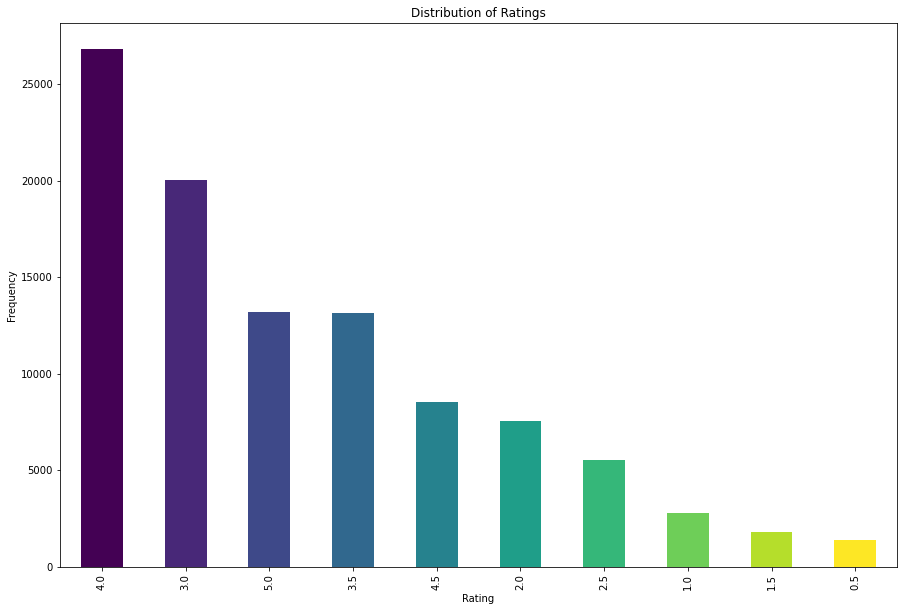

In [5]:
# Explore the rating distribution
import matplotlib.pyplot as plt 
import numpy as np
# visualize the rating column
rating_type= df['rating'].value_counts()# Establish  figure size
plt.figure(figsize=(15, 10))
num_bars = len(rating_type)
colors = plt.cm.viridis(np.linspace(0, 1, num_bars)) 
# Plot the data
rating_type.plot(kind='bar', color=colors)

# Label the plot
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Frequency")

# Show the plot
plt.show()

# Rating Distribution 
Rating are either implicit or explicit. Explicit ratings/feedback occurs when users directly rates the item for example giving a news item the thumbs down. In this case the explicit rating is on a scale 0-5.  Implicit rating/feedback makes assumptions about a user's preference based on their actions towards items for example how long the user interacted with the movies.

The data distributed indicates a positive ratings of movies  are more common. These higher ratings suggest that users are generally satisfied with the  movies. There may be a positive bias in the ratings. The data distibution and business task may influence the model's performance. 
.

In [6]:
# Calculate the percentage distribution of the rating column
rating_percentages = df['rating'].value_counts(normalize=True) * 100

# Display the percentages
print(rating_percentages)

4.0    26.595660
3.0    19.880797
5.0    13.101472
3.5    13.027093
4.5     8.480106
2.0     7.488397
2.5     5.503987
1.0     2.787695
1.5     1.776151
0.5     1.358642
Name: rating, dtype: float64


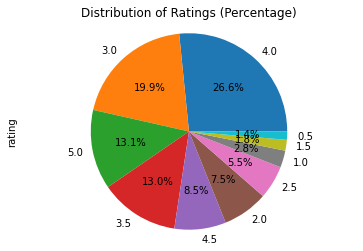

In [7]:
# Visualize the percentage rating 
rating_percentages.plot(kind='pie', autopct='%1.1f%%')

plt.title("Distribution of Ratings (Percentage)")
plt.axis('equal')

# Show the plot
plt.show()

# Ratings Percentage Distribution
Percentage distribution of ratings skews toward higher ratings, which could be an indication of positive bias.

* Ratings 4.0 and above: The combined percentage for ratings 4.0, 4.5, and 5.0 is about 48.17%. 4.0 (26.60%),
* Ratingd 3.0 to 3.5:  Makes  up 32.91% of the ratings 
* Ratings below 3.0: Account for a much smaller portion of the ratings ( 18.91%). 

Implication of this postive bias will likely skew recommendations toward high-rated movies and may not truly reflect the users' diverse preferences.

To address the issue the following strategies can be used .
* Normalization of the ratings  to account for individual user bias toward higher ratings.
* Regularization  of the ALS model(matrix factorization) to reduce the impact of extreme ratings by preventing the model from overfitting to popular, positively rated items.

 # Distribution of ratings across users
To understand the distribution of the number of ratings across many users the histogram will be used 

In [8]:
gb_user=df['userId'].value_counts()
gb_user

414    2698
599    2478
474    2108
448    1864
274    1346
       ... 
406      20
595      20
569      20
431      20
442      20
Name: userId, Length: 610, dtype: int64

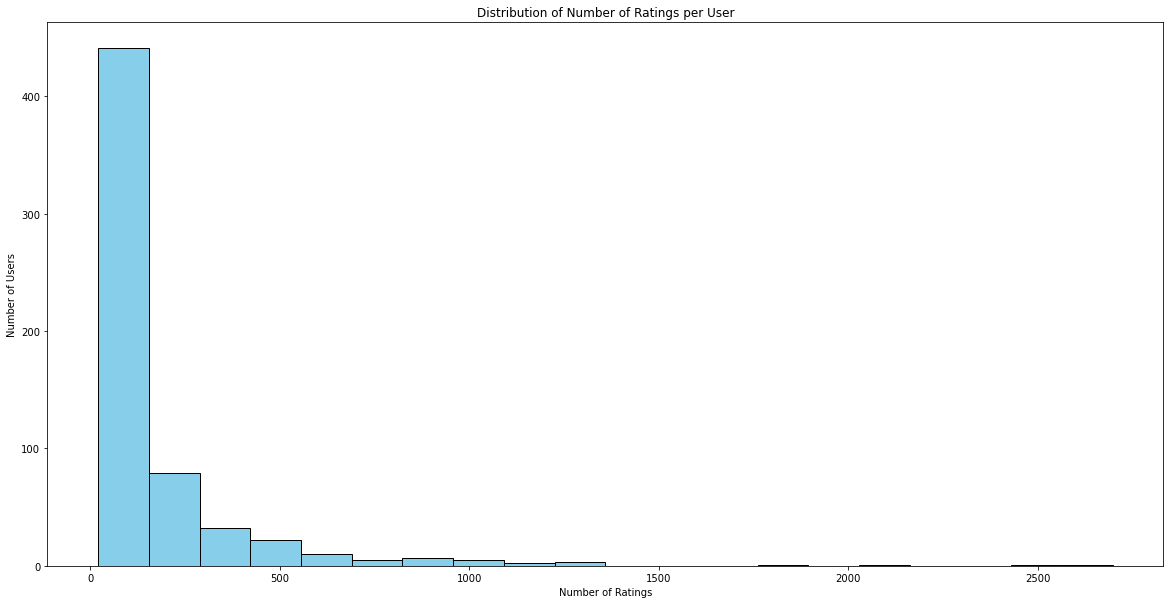

In [9]:
# Count the number of ratings per user
gb_user=df['userId'].value_counts()
# Plot the  distribution of the number of ratings by user
plt.figure(figsize=(20, 10))
plt.hist(gb_user, bins=20, color='skyblue', edgecolor='black')
plt.title("Distribution of Number of Ratings per User")
plt.xlabel("Number of Ratings")
plt.ylabel("Number of Users")
plt.show()

# Distribution of Ratings Across Users

The majority of users fall into the first bin, suggesting that many users might have rated few movies. This suggest low engagement in terms of ratings. Since users maybe rating fewer items this maybe leading to sparse datasets. In contrast there are fewer users with high rating engagements which could have a significant impact on the recommendation model. 

 To address sparsity, matrix factorization techniques like Alternating Least Squares will be used. 

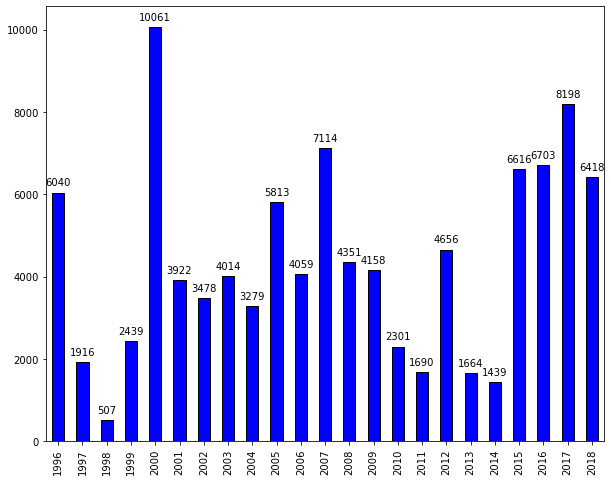

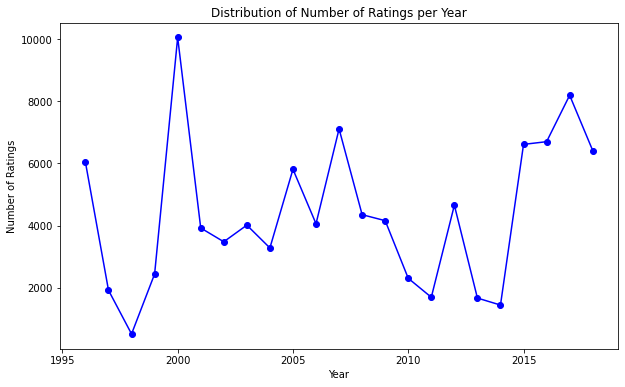

In [10]:
# Count the number of ratings per year
gb_year=df['year'].value_counts().sort_index()
# Plot the  distribution of the number of ratings by year
plt.figure(figsize=(10, 8))

ax=gb_year.plot(kind='bar',    linestyle='-',color='blue', edgecolor='black')

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
# Plot a line graph to visualize the trend
plt.figure(figsize=(10, 6))
plt.plot(gb_year.index, gb_year.values, marker='o', linestyle='-', color='b')


plt.title("Distribution of Number of Ratings per Year")
plt.xlabel("Year")
plt.ylabel("Number of Ratings")
plt.show()

# Model selection

To address the business problem collabiarative filtering CF approaches will be considered. 

## Collaborative Filtering  Approaches
* User-based filtering- recommends items to the target user based on preferences of other users.
* Item based filtering - recommends new items to the target user based on the user’s previous interactions with similar items
* Model based CF -Model-based approach creates a predictive machine learning model of the data. The present values in the utility matrix are used as the training data while predictions are made on the interactions that are yet to occur. 

Model based collaborative filtering will be used to address the business problem,  specifically  Sparks from MLlib. 

In [11]:
#Importing the required pyspark library 
from pyspark.sql import SparkSession  
import numpy as np 

In [12]:
from pyspark.sql import SparkSession 
# Initialize  spark session 
 
spark = SparkSession.builder.appName('Recommender').getOrCreate() 
spark

# Load and prepare data

In [13]:
# Read data from the ratings dataset . 
ratings_data = spark.read.csv('ratings.csv', inferSchema=True,header=True) 
ratings_data.show(5) 

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     47|   5.0|964983815|
|     1|     50|   5.0|964982931|
+------+-------+------+---------+
only showing top 5 rows



In [14]:
from pyspark.sql.functions import from_unixtime, year

# Convert  timestamp to year
ratings_df = ratings_data.withColumn('year', year(from_unixtime('timestamp'))).drop('timestamp')

# Show the result
ratings_df.show(5)

+------+-------+------+----+
|userId|movieId|rating|year|
+------+-------+------+----+
|     1|      1|   4.0|2000|
|     1|      3|   4.0|2000|
|     1|      6|   4.0|2000|
|     1|     47|   5.0|2000|
|     1|     50|   5.0|2000|
+------+-------+------+----+
only showing top 5 rows



In [15]:
# Describe dataset
ratings_df.describe().show()

+-------+------------------+----------------+------------------+------------------+
|summary|            userId|         movieId|            rating|              year|
+-------+------------------+----------------+------------------+------------------+
|  count|            100836|          100836|            100836|            100836|
|   mean|326.12756356856676|19435.2957177992| 3.501556983616962|2007.7226189059463|
| stddev| 182.6184914635004|35530.9871987003|1.0425292390606342| 6.890283870015307|
|    min|                 1|               1|               0.5|              1996|
|    max|               610|          193609|               5.0|              2018|
+-------+------------------+----------------+------------------+------------------+



All 100,836 movie entries have a rating, with maximum rating of 5 and minimum of 0.5. There are 610 user ids indicating that users are rating multiple movies.The average rating is 3.5.

In [16]:
ratings_df=ratings_df.drop('year')
ratings_df.show()

+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|     1|      1|   4.0|
|     1|      3|   4.0|
|     1|      6|   4.0|
|     1|     47|   5.0|
|     1|     50|   5.0|
|     1|     70|   3.0|
|     1|    101|   5.0|
|     1|    110|   4.0|
|     1|    151|   5.0|
|     1|    157|   5.0|
|     1|    163|   5.0|
|     1|    216|   5.0|
|     1|    223|   3.0|
|     1|    231|   5.0|
|     1|    235|   4.0|
|     1|    260|   5.0|
|     1|    296|   3.0|
|     1|    316|   3.0|
|     1|    333|   5.0|
|     1|    349|   4.0|
+------+-------+------+
only showing top 20 rows



In [17]:
# Read data from the movies dataset . 
movies_data = spark.read.csv('movies.csv', inferSchema=True,header=True) 
movies_data=movies_data.na.drop()
movies_data.show(5) 

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
+-------+--------------------+--------------------+
only showing top 5 rows




# Train A Model

## Import the Alternating Least Squares(ALS) Method and apply it.


* rank: the number of latent factors in the model (defaults to 10).
* maxIter:  is the maximum number of iterations to run (defaults to 10).
* regParam: specifies the regularization parameter in ALS (defaults to 1.0).
* implicitPrefs:  specifies whether to use the explicit feedback or  implicit feedback data (defaults to false - means using explicit feedback).
* nonnegative: specifies whether or not to use nonnegative constraints for least squares (defaults to false).

In [18]:
# Split and train  ratings dataset
# Dividing the data using random split into train_data 80%  and test_data 20%  
train_data, test_data = ratings_df.randomSplit([0.8, 0.2], seed=42)

In [19]:
# Import the Alternating Least Squares(ALS) Method and apply it.
from pyspark.ml.recommendation import ALS 
# Build the recommendation model using ALS  default params on the training data 
als = ALS( coldStartStrategy="drop", # to address cold start problem 
          userCol="userId",
          itemCol="movieId", 
          ratingCol="rating",
          seed=42,
         )
#Fit the model on the train_data 
model = als.fit(train_data)

# Cold Start Strategy
Cold start issues arise when there is insufficient data to match users with items. This can happen in several situations
* new users or items that have no rating history and on which the model has not been trained
* encounter users and/or items in the evaluation set that are not in the training set
* sparse interaction as some users or items may be present in the training data but have very few interactions

These situations can result in poor generalization, weak predictions, and potential overfitting on items with high user interactions. To address the issue  coldStartStrategy="drop"  to remove any rows in the DataFrame of predictions that contain NaN values.

# Make Predictions with  Model
The trained model can be used to predict ratings with a given test data.

In [20]:
# Create predictions on the test data 
predictions = model.transform(test_data) 

#Displaying predictions calculated by the model 
predictions.show()

+------+-------+------+----------+
|userId|movieId|rating|prediction|
+------+-------+------+----------+
|   463|   1088|   3.5| 3.9879189|
|   580|   3175|   2.5| 3.7096252|
|   580|  44022|   3.5| 3.4450464|
|   362|   1645|   5.0| 3.6496258|
|   597|   1959|   4.0|   4.04303|
|   155|   3175|   4.0|  3.466539|
|   368|   2122|   2.0| 2.4186718|
|   115|   1645|   4.0| 2.8170109|
|   115|   3175|   4.0|  4.126749|
|    28|   1645|   2.5| 2.4221506|
|    28|   3175|   1.5| 3.3600736|
|   587|   1580|   4.0|  4.158138|
|   332|   1645|   3.5| 2.9700162|
|   332|   2366|   3.5| 3.6067934|
|   577|   1580|   3.0| 3.3414087|
|   577|   1959|   4.0| 3.6017723|
|   271|   6658|   2.0| 2.6535034|
|   606|   1088|   3.0| 3.5428398|
|    91|   1580|   3.5|  3.391724|
|    91|   6620|   3.5| 3.4276881|
+------+-------+------+----------+
only showing top 20 rows



# Predictions 
* For higher actual ratings (e.g., 5 ) the model tends to predict lower values (e.g.,3.6 ). This suggests the model might not fully capture the user’s strong preference for certain items, leading to underprediction.
* For lower actual ratings (e.g., 1.5 ), the model sometimes predicts higher values (e.g., 3.3 ). This might indicate that the model is overestimating the user’s interest in some items, particularly for lower ratings.

* The model seems to perform reasonably well for mid-range ratings (e.g., 3.5)

# Model Evaluations

In [21]:
from pyspark.ml.evaluation import RegressionEvaluator 

#Create evaluator for each metric 
rmse_evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",predictionCol="prediction") 
mae_evaluator = RegressionEvaluator(metricName="mae", labelCol="rating", predictionCol="prediction")


# Calculate the metrics
rmse = rmse_evaluator.evaluate(predictions)
mae = mae_evaluator.evaluate(predictions)

# Print the results
print("Root Mean Square Error RMSE = " + str(rmse))

print("Mean Absolute Error (MAE) = "+ str(mae))


Root Mean Square Error RMSE = 0.8813828296669005
Mean Absolute Error (MAE) = 0.6782378941236188


Interpretation

The evaluation metrics measure the accuracy of the model's prediction.

 RMSE = 0.8813
 
* The root mean square error penalizes larger errors more than smaller errors, therefore a smaller RMSE is a more accurate measure when the goal is to minimize the effects of large errors. 

* RMSE provides a sense of how far the predictions are from the actual values. 
    
MAE=0.678
 
* Mean absolute errors MAE measures the averages of the absolute differences between predicted and actual values, without penalizing larger errors more.
* Lower MAE measure indicates a better performing model.
    
The model performance indicates there maybe some errors in the predictions. To address the issue the model will be hypertuned to find the best parameters. 

# Hyperparameter tuning

RMSE is very high, the default parameters were used to train the model. Hyperparameter tuning will be used to determine the best parameters for the business task by applying a range of parameters. ParamGridBuilder utility will be used before running model selection with CrossValidator 

In [22]:
from pyspark.ml.tuning import ParamGridBuilder , CrossValidator
als = ALS(nonnegative=True,
          implicitPrefs=False,
          coldStartStrategy="drop",
          userCol="userId",
          itemCol="movieId",
          ratingCol="rating",
          seed=42
         )

# Add hyperparameters and their respective values to paramGrid
paramGrid =(ParamGridBuilder()
            .addGrid(als.rank, [5, 8 ])                    # number of latent factors in the model
            .addGrid(als.maxIter, [5, 10, 15 ])                     # maximum number of iterations to run
            .addGrid(als.regParam, [  0.2, 0.5]) .build()) # specifies the regularization parameter in ALS

 

# Create a RegressionEvaluator for RMSE
evaluator_rsme = RegressionEvaluator(metricName="rmse",
                                labelCol="rating",
                                predictionCol="prediction")


 # Initialize the  crossValidator - crossvalidator to improve generalization    
cv = CrossValidator(estimator=als,
                    evaluator=evaluator_rsme ,
                    estimatorParamMaps=paramGrid,
                    parallelism=2,  # 2 models will be trained and evaluated at the same time.
                    numFolds=5)  # split the dataset into a set of non-overlapping randomly partitioned folds 

In [23]:
# Fit the model
model = cv.fit(train_data)

# Extract the best model from hypertuning exercise using ParamGridBuilder
bestModel = model.bestModel


# Print details of the best model
print("Best Model Parameters:")
print(f" Rank: {bestModel.rank}")
print(f" Max Iterations: {bestModel._java_obj.parent().getMaxIter()}")
print(f" Regularization Parameter: {bestModel._java_obj.parent().getRegParam()}")

Best Model Parameters:
 Rank: 8
 Max Iterations: 15
 Regularization Parameter: 0.2


Best model parameter 
*  Rank of 8 indicates a lower number of latent factors  capturing the user-item interactions and  reduced risk of overfitting(rank determines dimensions the matrices) 
* Max Iterations of 15 is the  the number of iterations the ALS algorithm  will run. More iterations allow the algorithm to reduce errors and converge to better solutions.
* Regularization Parameter of 0.2 applies a moderate penalty to user item latent factor values, preventing the model from overfitting while allowing it to capture patterns in the data

In [24]:
# Get the average cross-validation metrics for each parameter combination
avg_metrics = model.avgMetrics
# Print the average RMSE for each parameter combination
print("Average RMSE for each param combination: ", avg_metrics)

Average RMSE for each param combination:  [0.9039029555248378, 1.0034918987106332, 0.8933141453266312, 1.0076494474507354, 0.8908520744206051, 1.0078349347443398, 0.8997652374608556, 1.0112454031255282, 0.8921953719503092, 1.0079759736084968, 0.8901533032486431, 1.0078614399084613]


In [25]:
# summarize the RMSE parameter combination 
# Calculate summary statistics
average_rmse = np.mean(avg_metrics)
min_rmse = np.min(avg_metrics)
max_rmse = np.max(avg_metrics)

print(f"Average RMSE: {average_rmse}")
print(f"Minimum RMSE (best parameter combination)=" + str(min_rmse)) 
print(f"Maximum RMSE (worst parameter combination)=" + str(max_rmse))


Average RMSE: 0.9513535154566731
Minimum RMSE (best parameter combination)=0.8901533032486431
Maximum RMSE (worst parameter combination)=1.0112454031255282


The average RMSE across all parameter combinations is 0.9514, indicatng  on average, the error between predicted and actual values is about 0.95 units.
The best parameter combination  or the lowest RMSE is 0.8903, indicates that this combination has the lowest prediction  error among all combinations.
The worst parameter combination or the highest RMSE is 1.011, indicatates  that this combination has the highest prediction error.

In [26]:
# Convert rsme to a dataframe 
# Extract parameter values for each model
param_combinations = [(params[als.rank], params[als.regParam]) for params in paramGrid]

rmse_df = pd.DataFrame(param_combinations, columns=["rank", "regParam"])
rmse_df["RMSE"] = avg_metrics


Text(51.0, 0.5, 'rank')

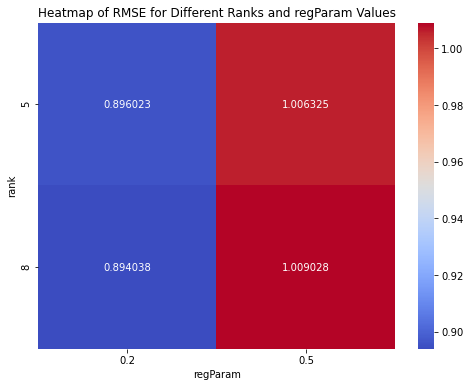

In [27]:
import seaborn as sns
# Visulaize the results
aggregated_df = rmse_df.groupby(['rank', 'regParam'], as_index=False).mean()

# Pivot the DataFrame for heatmap
pivot_df = aggregated_df.pivot("rank", "regParam", "RMSE")

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_df, annot=True, cmap="coolwarm", fmt=".6f")

# Customize the plot
plt.title("Heatmap of RMSE for Different Ranks and regParam Values")
plt.xlabel("regParam")
plt.ylabel("rank")

# Recommendations 

Now that the model is tuned, I will use the trained model to predict and recommend movies. 

In [28]:
# Use the hypertuned model with correct parameters 
# Initialize ALS with the correct parameters
als = ALS(nonnegative=True,
                implicitPrefs=False,
                coldStartStrategy="drop",
                rank=8,
                maxIter=15,
                regParam=0.2,
                userCol="userId",
                itemCol="movieId",
                ratingCol="rating",
                  seed=42)

Parameter explained
* nonnegative=True: The factorization produces only nonnegative values.
* implicitPrefs=False:  the ALS model will be trained using explicit feedback (ratings).
* coldStartStrategy="drop": drops predictions for users or items in the test set that do not appear in the training set
* rank=8: The number of latent factors in the model.
* maxIter=15: The number of iterations to run.
* regParam=0.2: The regularization parameter.

In [29]:
# Fit the final model
final_model = als.fit(train_data)

In [30]:
# Calculate predictions of the final_model
final_pred = final_model.transform(test_data)

#Displaying predictions calculated by the model 
final_pred.show(5)

+------+-------+------+----------+
|userId|movieId|rating|prediction|
+------+-------+------+----------+
|   463|   1088|   3.5| 3.5360005|
|   580|   3175|   2.5| 3.4495802|
|   580|  44022|   3.5|   3.12542|
|   362|   1645|   5.0| 3.7763581|
|   597|   1959|   4.0|  4.059897|
+------+-------+------+----------+
only showing top 5 rows



In [31]:
# To display title for prediction 
# Join the ratings_data and movie_data 
pred=final_pred.join(movies_data, 'movieId').select('userId','title','prediction','genres')
pred.show(5)

+------+--------------------+----------+--------------------+
|userId|               title|prediction|              genres|
+------+--------------------+----------+--------------------+
|   463|Dirty Dancing (1987)| 3.5360005|Drama|Musical|Rom...|
|   580| Galaxy Quest (1999)| 3.4495802|Adventure|Comedy|...|
|   580|Ice Age 2: The Me...|   3.12542|Adventure|Animati...|
|   362|The Devil's Advoc...| 3.7763581|Drama|Mystery|Thr...|
|   597|Out of Africa (1985)|  4.059897|       Drama|Romance|
+------+--------------------+----------+--------------------+
only showing top 5 rows



# Evaluation 

In [32]:
#  Model acurracy 
from pyspark.sql import functions as F
from pyspark.sql.functions import sqrt, pow
# Calculate RMSE for each user
user_rmse = final_pred.groupBy("userId").agg(
    sqrt(F.mean(pow(F.col("rating") - F.col("prediction"), 2))).alias("RMSE"))


#  Join RMSE back to the original DataFrame
predictions_rmse = final_pred.join(user_rmse, on="userId", how="left")

# Display the final DataFrame with RMSE included
predictions_rmse.show()

+------+-------+------+----------+------------------+
|userId|movieId|rating|prediction|              RMSE|
+------+-------+------+----------+------------------+
|   463|   1088|   3.5| 3.5360005| 0.487734900120663|
|   580|   3175|   2.5| 3.4495802|1.1017128881257234|
|   580|  44022|   3.5|   3.12542|1.1017128881257234|
|   362|   1645|   5.0| 3.7763581|   0.5465907880391|
|   597|   1959|   4.0|  4.059897|0.9101306540246756|
|   155|   3175|   4.0| 3.5469859|0.9863687417179362|
|   368|   2122|   2.0| 2.2189863|0.6386716294134778|
|   115|   1645|   4.0| 3.4880972|1.1619022794691902|
|   115|   3175|   4.0| 3.6221485|1.1619022794691902|
|    28|   1645|   2.5| 2.8079262|0.7904295010181651|
|    28|   3175|   1.5| 2.8566742|0.7904295010181651|
|   587|   1580|   4.0| 3.6748192|0.7866470210003113|
|   332|   1645|   3.5| 3.1721878|0.6258444615155864|
|   332|   2366|   3.5| 3.3894088|0.6258444615155864|
|   577|   1580|   3.0| 3.2254906|0.7563781533866525|
|   577|   1959|   4.0| 3.47

In [33]:
#Create evaluator for each metric 
rmse_evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",predictionCol="prediction") 


# Calculate the metrics
rmse = rmse_evaluator.evaluate(final_pred)

# Print the results
print("Root Mean Square Error RMSE = " + str(rmse))


Root Mean Square Error RMSE = 0.8753373355232398


### Model's Prediction Acurracy

* The model is performing well for most users, with RMSE values below 1.0, indicative of fairly accurate predictions.
* Users with lower RMSE (e.g., User 463) seem to have more accurate predictions, suggesting their behavior is better captured by the model.
* Higher RMSE indicates that user (e,g., user 362 ) may have less predictable behavior, or the model might need better tuning for this specific case.
* The average RMSE of the predictions is 0.8753 a slight improvement from the baseline model of 0.8813


# Develop Recommendations

To address the business problem, the recommendation system will be designed to:

* Generate the top 5 recommended movies for each user
* Generate the top 5 recommended users for each movie

In [34]:
# Top 5 recommended movies  for each users 
userRecommend = final_model.recommendForAllUsers(5)
userRecommend.show(5)

+------+--------------------+
|userId|     recommendations|
+------+--------------------+
|     1|[{96004, 6.027355...|
|     2|[{141718, 4.86681...|
|     3|[{6835, 4.7739754...|
|     4|[{3851, 4.7564926...|
|     5|[{132333, 4.90103...|
+------+--------------------+
only showing top 5 rows



Predictions are greater than the rating scale.  this is due to the nature of matrix factorization and the lack of model's constraints to the original ratings scale. To address and improve explainability the ratings values will be restricted to the original rating scale. 

In [35]:
from pyspark.sql.functions import explode,col, when
# Explode the recommendations array into individual rows
exploded_rec = userRecommend.withColumn("recommendation", explode("recommendations"))

# Select the userId, movieId, and rating from the exploded DataFrame
exploded_rec = exploded_rec.select(
    col("userId"),
    col("recommendation.movieId").alias("movieId"),
    col("recommendation.rating").alias("pred_rating"))

# Restrict predicted ratings to be between 0 and 5
exploded_rec = exploded_rec.withColumn(
    "pred_rating", 
    when(col("pred_rating") > 5, 5).otherwise(col("pred_rating")))
exploded_rec.show(5)



+------+-------+-----------+
|userId|movieId|pred_rating|
+------+-------+-----------+
|     1|  96004|        5.0|
|     1|   3379|        5.0|
|     1| 132333|        5.0|
|     1| 141718|        5.0|
|     1|  60943|        5.0|
+------+-------+-----------+
only showing top 5 rows



Improve readability

The predictions lack interpretability and should therefore be transformed into a more understandable format. The movies dataset will be utilized to enhance readability.

In [36]:
#Improving the Readability
final_rec = exploded_rec.join(movies_data, "movieId")
#Select the necessary columns
final_rec = final_rec.select(
    col("userId"),
    col("title"),
    col("pred_rating"))
    
final_rec.show(5, truncate=False)

+------+-----------------------------------------------------------------------------------------------------------------------------+-----------+
|userId|title                                                                                                                        |pred_rating|
+------+-----------------------------------------------------------------------------------------------------------------------------+-----------+
|1     |Dragon Ball Z: The History of Trunks (Doragon bôru Z: Zetsubô e no hankô!! Nokosareta chô senshi - Gohan to Torankusu) (1993)|5.0        |
|1     |On the Beach (1959)                                                                                                          |5.0        |
|1     |Seve (2014)                                                                                                                  |5.0        |
|1     |Deathgasm (2015)                                                                                              

# Evaluate Accuracy of Top 5 Movies Recommended for Each User

In addition to RMSE, the Precision@K evaluation metric will be used to assess the accuracy. This metric compares the relevance of the top 5 recommended movies to a set of relevant movies for each user (ground truth).

In [37]:
#Join the actual ratings with the predicted ratings
ratings_with_predictions = ratings_df.join(exploded_rec, on=["userId", "movieId"])

# Show the DataFrame with actual ratings and predictions
ratings_with_predictions.show(5)

+------+-------+------+-----------+
|userId|movieId|rating|pred_rating|
+------+-------+------+-----------+
|     3|   6835|   5.0|  4.7739754|
|     3|   5746|   5.0|  4.7739754|
|     3|   5181|   5.0|   4.630731|
|     3|   4518|   5.0|   4.447957|
|     3|   7899|   4.5|   4.296578|
+------+-------+------+-----------+
only showing top 5 rows



In [38]:
#Create evaluator for each metric 
rmse_evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",predictionCol="pred_rating") 

# Calculate the metrics
rmse = rmse_evaluator.evaluate(ratings_with_predictions )

# Print the results
print(" Top 5 movies recommendation for each user Root Mean Square Error RMSE = " + str(rmse))

 Top 5 movies recommendation for each user Root Mean Square Error RMSE = 0.44641961507467764


In [39]:
from pyspark.sql.functions import when, sum, count

# Set relevance as items with predicted rating >= 4.5
ratings_with_predictions = ratings_with_predictions.withColumn("is_relevant", when(col("pred_rating") >= 4.5, 1).otherwise(0))

ratings_with_predictions.show(5)


+------+-------+------+-----------+-----------+
|userId|movieId|rating|pred_rating|is_relevant|
+------+-------+------+-----------+-----------+
|     3|   6835|   5.0|  4.7739754|          1|
|     3|   5746|   5.0|  4.7739754|          1|
|     3|   5181|   5.0|   4.630731|          1|
|     3|   4518|   5.0|   4.447957|          0|
|     3|   7899|   4.5|   4.296578|          0|
+------+-------+------+-----------+-----------+
only showing top 5 rows



In [40]:
# Calculate Precision@K for each user
precision_at_k = ratings_with_predictions.groupBy("userId") \
    .agg((sum("is_relevant") / count("movieId")).alias("precision_at_k"))

precision_at_k.show(5)


+------+--------------+
|userId|precision_at_k|
+------+--------------+
|   516|           1.0|
|   255|           0.0|
|    28|           0.0|
|   596|           1.0|
|    76|           0.0|
+------+--------------+
only showing top 5 rows



In [41]:
from pyspark.sql.functions import avg

# Calculate the average Precision@K across all users
avg_precision_at_k = precision_at_k.agg(avg("precision_at_k").alias("avg_precision_at_k")).collect()[0][0]

print(f"Average Precision@K across all users with 4.5 relevance: {avg_precision_at_k}")

Average Precision@K across all users with 4.5 relevance: 0.6614035087719298


In [42]:
# Calculate Precsion@K with a lenient  threshold

# Set relevance as movies with predicted rating >= 4.0
ratings_with_predictions = ratings_with_predictions.withColumn("is_relevant", when(col("pred_rating") >= 4.0, 1).otherwise(0))


# Calculate Precision@K for each user
precision_at_k = ratings_with_predictions.groupBy("userId") \
    .agg((sum("is_relevant") / count("movieId")).alias("precision_at_k"))


# Calculate the average Precision@K across all users
avg_precision_at_k = precision_at_k.agg(avg("precision_at_k").alias("avg_precision_at_k")).collect()[0][0]

print(f"Average Precision@K across all users with 4.0 relevance: {avg_precision_at_k}")

Average Precision@K across all users with 4.0 relevance: 0.8763157894736842



# Model Predicted Ratings and Evaluation for Top 5 Movies per User

Top 5 movies recommendation  per user, Root Mean Square Error (RMSE) = 0.4464.  

The RMSE value of 0.4464 indicates that:
* The predicted ratings deviate from the actual ratings by approximately 0.45 units.This means the predicted rating for 4 is around 4 ± 0.45.
* The model is performing well and recommending  relevant movies with the predicted ratings  close to what the users might actually rate the movies.

Average Precision@K across all users:

* With a 4.5 relevance threshold: 0.6614
* With a 4.0 relevance threshold: 0.8763

Precision@K evaluates how many of the top K recommended items are actually relevant, averaged across all users. 

A score of 0.66 for a 4.5 relevance threshold means:
*  66% of the top 5 recommended movies for each user are considered relevant based on the ground truth( actual rating).
* 66% of the top K recommended movies are considered relevant when the predicted rating is  >= 4.5.
* Recommendation system is performing well in identifying relevant movies.

With a less conservative  4.0 relevance threshold,  Average Precision@K across all users is  0.8763. The less restrictive threshold indicated the 87% of the top movies recommended are considered relevant or liked/enjoyed by the user at this lower threshold.



# Top k (5) users recommendations for each movie

In [43]:
## Generate top 5 user recommendations for each movie
movieRecommend = final_model.recommendForAllItems(5)
movieRecommend.show(5)

+-------+--------------------+
|movieId|     recommendations|
+-------+--------------------+
|     12|[{53, 3.548811}, ...|
|     26|[{53, 4.6274834},...|
|     27|[{53, 4.2163386},...|
|     28|[{53, 5.1923447},...|
|     31|[{43, 4.30455}, {...|
+-------+--------------------+
only showing top 5 rows



In [44]:
# Explode the recommendations array into individual rows
exploded_rec_mov = movieRecommend.withColumn("recommendation", explode("recommendations"))

# Select the userId, movieId, and rating from the exploded DataFrame
exploded_rec_mov = exploded_rec_mov.select(
    col("movieId"),
    col("recommendation.userId").alias("userId"),
    col("recommendation.rating").alias("pred_rating"))

# Restrict predicted ratings to be between 0 and 5
exploded_rec_mov = exploded_rec_mov.withColumn(
    "pred_rating", 
    when(col("pred_rating") > 5, 5).otherwise(col("pred_rating")))
exploded_rec_mov.show(5)

+-------+------+-----------+
|movieId|userId|pred_rating|
+-------+------+-----------+
|     12|    53|   3.548811|
|     12|   558|  3.3245075|
|     12|   327|  3.2381494|
|     12|   371|  3.0953596|
|     12|   276|  3.0835876|
+-------+------+-----------+
only showing top 5 rows



In [45]:
#Improving the Readability
movie_rec = exploded_rec_mov.join(movies_data, "movieId")
#Select the necessary columns
movie_rec = movie_rec.select(
    col("userId"),
    col("title"),
    col("pred_rating"))
    
movie_rec.show(5, truncate=False)

+------+----------------------------------+-----------+
|userId|title                             |pred_rating|
+------+----------------------------------+-----------+
|53    |Dracula: Dead and Loving It (1995)|3.548811   |
|558   |Dracula: Dead and Loving It (1995)|3.3245075  |
|327   |Dracula: Dead and Loving It (1995)|3.2381494  |
|371   |Dracula: Dead and Loving It (1995)|3.0953596  |
|276   |Dracula: Dead and Loving It (1995)|3.0835876  |
+------+----------------------------------+-----------+
only showing top 5 rows



# Evaluate accuracy top 5 users recommendation  for each movie

In [46]:
#join the actual ratings with the predicted ratings
ratings_with_predictions = ratings_df.join(exploded_rec_mov, on=["userId", "movieId"])

# Show the DataFrame with actual ratings and predictions
ratings_with_predictions.show(5)

+------+-------+------+-----------+
|userId|movieId|rating|pred_rating|
+------+-------+------+-----------+
|   276|     12|   4.0|  3.0835876|
|   337|     27|   5.0|  4.1199965|
|    43|     34|   5.0|  4.5032105|
|    93|     34|   5.0|    4.30086|
|   243|     44|   4.0|  3.2098145|
+------+-------+------+-----------+
only showing top 5 rows



In [47]:
#Create evaluator for each metric 
rmse_evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",predictionCol="pred_rating") 

# Calculate the metrics
rmse = rmse_evaluator.evaluate(ratings_with_predictions)

# Print the results
print(" Top 5 users recommendation  for each movie Root Mean Square Error RMSE = " + str(rmse))

 Top 5 users recommendation  for each movie Root Mean Square Error RMSE = 0.6255810663017815


In [48]:
# Evalaute Precision@K
# Calculate Precsion@K with a conservative threshold

# Define relevance as users with predicted rating >= 4.5
ratings_with_predictions = ratings_with_predictions.withColumn("is_relevant", when(col("pred_rating") >= 4.5, 1).otherwise(0))
ratings_with_predictions.show(5)

# Calculate Precision@K for each movies
precision_at_k = ratings_with_predictions.groupBy("movieId") \
    .agg((sum("is_relevant") / count("userId")).alias("precision_at_k"))


# Calculate the average Precision@K across all movies
avg_precision_at_k = precision_at_k.agg(avg("precision_at_k").alias("avg_precision_at_k")).collect()[0][0]

print(f"Average Precision@K across all movies with 4.5 relevance: {avg_precision_at_k}")

+------+-------+------+-----------+-----------+
|userId|movieId|rating|pred_rating|is_relevant|
+------+-------+------+-----------+-----------+
|   276|     12|   4.0|  3.0835876|          0|
|   337|     27|   5.0|  4.1199965|          0|
|    43|     34|   5.0|  4.5032105|          1|
|    93|     34|   5.0|    4.30086|          0|
|   243|     44|   4.0|  3.2098145|          0|
+------+-------+------+-----------+-----------+
only showing top 5 rows

Average Precision@K across all movies with 4.5 relevance: 0.2830076968620485


In [49]:
# Calculate Precsion@K with a lenient threshold

# Set relevance as items with predicted rating >= 4.0
ratings_with_predictions = ratings_with_predictions.withColumn("is_relevant", when(col("pred_rating") >= 4.0, 1).otherwise(0))


# Calculate Precision@K for each user
precision_at_k = ratings_with_predictions.groupBy("movieId") \
    .agg((sum("is_relevant") / count("userId")).alias("precision_at_k"))


# Calculate the average Precision@K across all users
avg_precision_at_k = precision_at_k.agg(avg("precision_at_k").alias("avg_precision_at_k")).collect()[0][0]

print(f"Average Precision@K across all movies with 4.0 relevance: {avg_precision_at_k}")

Average Precision@K across all movies with 4.0 relevance: 0.5944345766725874


# Model Predicted Ratings and Evaluation for Top 5 Users per Movie 

Top 5 users recommendation  for each movie Root Mean Square Error (RMSE) = 0.6255

The RMSE value of  0.6255 implies:
* For a movie with higher actual user rating of 4.0, the model’s prediction will likely be between 3.37 and 4.63.
* For a movie with an actual rating of 2.0, the model's prediction will likely fall between 1.37 and 2.63.
* Small average differences (0.63 units) suggest that the model is approximating user ratings

Average Precision@K across all movies:

*  With 4.5 relevance: 0.2830
*  With 4.0 relevance: 0.5944

Stricter Threshold (4.5) :
* Precision@K = 0.28 at 4.5 relevance: The stricter threshold results in lower precision because fewer users rate movies ≥ 4.5. This suggests that model is making recommendations, fewer of the recommendations are meeting the top preference level.

Lenient Threshold (4.0)
* Precision@K = 0.59 at 4.0 relevance: 
* The system performs much better with a threshold of 4.0, where more users are satisfied with the recommendations, finding them moderately enjoyable

 The 4.5  relevance threshold is more useful when the focus is on recommending movies that users will love, not just like,  ensures strong relevance but at the cost of precision.

The 4.0 relevance threshold, being more lenient, captures a broader range of user satisfaction, resulting in higher precision, as more users find the recommendations enjoyable.


# Proof of concept 
To demonstrate that the recommendation system functions a subset of user will be used as well as a subset of movies. Accuracy will be tested and compared. 


In [71]:
# select 20 distinct user and recommend 5 movies to each 
# Select subset of users (20) 
users= ratings_df.select('userId').distinct(). limit(20)
users.show()

+------+
|userId|
+------+
|   148|
|   463|
|   471|
|   496|
|   243|
|   392|
|   540|
|    31|
|   516|
|    85|
|   137|
|   251|
|   451|
|   580|
|    65|
|   458|
|    53|
|   255|
|   481|
|   588|
+------+



In [72]:
# Recommend 5 movies to each user in the subset
userSubsetRec= final_model.recommendForUserSubset(users,5)
# Explode the recommendations array into individual rows
exploded_rec_user = userSubsetRec.withColumn("recommendation", explode("recommendations"))

# Select the userId, movieId, and rating from the exploded DataFrame
exploded_rec_user = exploded_rec_user.select(
    col("userId"),
    col("recommendation.movieId").alias("movieId"),
    col("recommendation.rating").alias("pred_rating"))

# Restrict predicted ratings to be between 0 and 5
exploded_rec_user = exploded_rec_user.withColumn(
    "pred_rating", 
    when(col("pred_rating") > 5, 5).otherwise(col("pred_rating")))
exploded_rec_user.show(5)

+------+-------+-----------+
|userId|movieId|pred_rating|
+------+-------+-----------+
|   540|  96004|        5.0|
|   540|   3379|        5.0|
|   540|  60943|        5.0|
|   540|  59018|        5.0|
|   540| 141718|        5.0|
+------+-------+-----------+
only showing top 5 rows



In [73]:
#Improving the Readability
distinct_user_rec = exploded_rec_user.join(movies_data, "movieId")
#Select the necessary columns
distinct_user_rec  = distinct_user_rec .select(
    col("userId"),
    col("title"),
    col("pred_rating"))
    
distinct_user_rec.show(5, truncate=False)

+------+-----------------------------------------------------------------------------------------------------------------------------+-----------+
|userId|title                                                                                                                        |pred_rating|
+------+-----------------------------------------------------------------------------------------------------------------------------+-----------+
|540   |Dragon Ball Z: The History of Trunks (Doragon bôru Z: Zetsubô e no hankô!! Nokosareta chô senshi - Gohan to Torankusu) (1993)|5.0        |
|540   |On the Beach (1959)                                                                                                          |5.0        |
|540   |Frozen River (2008)                                                                                                          |5.0        |
|540   |Visitor, The (2007)                                                                                           

In [74]:
exploded_rec_user.printSchema()

root
 |-- userId: integer (nullable = false)
 |-- movieId: integer (nullable = true)
 |-- pred_rating: float (nullable = true)



In [75]:
# Evaluate the accuracy 
# Join distinct users with actual ratings DataFrame
user_actual_ratings = users.join(ratings_df, on="userId", how="right")

#join the actual ratings for distinct users with the predicted ratings
ratings_with_predictions = exploded_rec_user.join(user_actual_ratings, on=["userId", 'movieId'], how = 'left')
ratings_with_pred = ratings_with_predictions.filter(col("rating").isNotNull())
ratings_with_pred.show()

# Show the DataFrame with actual ratings and predictions
ratings_with_predictions.show(5)

+------+-------+-----------+------+
|userId|movieId|pred_rating|rating|
+------+-------+-----------+------+
|   255|   1739|  3.7659633|   4.0|
|   516|   4429|  4.7330747|   5.0|
+------+-------+-----------+------+

+------+-------+-----------+------+
|userId|movieId|pred_rating|rating|
+------+-------+-----------+------+
|   540|  96004|        5.0|  NULL|
|   540|   3379|        5.0|  NULL|
|   540|  60943|        5.0|  NULL|
|   540|  59018|        5.0|  NULL|
|   540| 141718|        5.0|  NULL|
+------+-------+-----------+------+
only showing top 5 rows



In [76]:
#Create evaluator for each metric 
rmse_evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",predictionCol="pred_rating") 

# Calculate the metrics
rmse = rmse_evaluator.evaluate(ratings_with_pred) 

# Print the results
print(" Recommend  5 distinct movies to  20  users ,  Root Mean Square Error RMSE = " + str(rmse))

 Recommend  5 distinct movies to  20  users ,  Root Mean Square Error RMSE = 0.25102022219574527


In [55]:
# Calculate Precsion@K with a conservative threshold

# Set relevance as items with predicted rating >= 4.5
exploded_rec_user= exploded_rec_user.withColumn("is_relevant", when(col("pred_rating") >= 4.5, 1).otherwise(0))

# Calculate Precision@K for each user
precision_at_k =exploded_rec_user.groupBy("userId") \
    .agg((sum("is_relevant") / count("movieId")).alias("precision_at_k"))

precision_at_k .show(5)
# Calculate the average Precision@K across all users
avg_precision_at_k = precision_at_k.agg(avg("precision_at_k").alias("avg_precision_at_k")).collect()[0][0]

print(f"Average Precision@K across distinct users with 4.5 relevance: {avg_precision_at_k}")

+------+--------------+
|userId|precision_at_k|
+------+--------------+
|   471|           1.0|
|   463|           1.0|
|   496|           1.0|
|   148|           0.8|
|   540|           1.0|
+------+--------------+
only showing top 5 rows

Average Precision@K across distinct users with 4.5 relevance: 0.8400000000000001


In [56]:
# Calculate Precsion@K with a lenient threshold

# Set relevance as items with predicted rating >= 4.0
exploded_rec_user= exploded_rec_user.withColumn("is_relevant", when(col("pred_rating") >= 4.0, 1).otherwise(0))

# Calculate Precision@K for each user
precision_at_k =exploded_rec_user.groupBy("userId") \
    .agg((sum("is_relevant") / count("movieId")).alias("precision_at_k"))

precision_at_k .show(5)
# Calculate the average Precision@K across all users
avg_precision_at_k = precision_at_k.agg(avg("precision_at_k").alias("avg_precision_at_k")).collect()[0][0]

print(f"Average Precision@K across distinct users with 4.0 relevance: {avg_precision_at_k}")

+------+--------------+
|userId|precision_at_k|
+------+--------------+
|   471|           1.0|
|   463|           1.0|
|   496|           1.0|
|   148|           1.0|
|   540|           1.0|
+------+--------------+
only showing top 5 rows

Average Precision@K across distinct users with 4.0 relevance: 0.96


# Evaluation  of Recommend 5 movies to 20 distinct users

The recommendation system was evaluated by recommending 5 movies to 20 distinct users.

 *  Root Mean Square Error RMSE = 0.25102022219574527
Indicates that the predicted ratings deviate from the actual ratings by a small margin of 0.25 units.
This suggests that the model is performing very well in predicting user preferences for the selected group of users and movies.

Average Precision@K across distinct users:

* With 4.5 relevance: 0.840
This shows that 84% of the top 5 recommended movies for each distinct user are considered highly relevant, based on a 4.5 rating threshold.

* With 4.0 relevance: 0.96
At a more lenient threshold, 96% of the recommended movies are considered relevant, meaning the recommendations closely match users' preferences when a 4.0 threshold is applied.

These metrics indicate that the recommendation system is highly effective at predicting and recommending relevant movies to users.

 # Generate  top 5 users recommendation for  distinct list of  movies

In [57]:
# Select subset of movies (5)
movies= ratings_df.select('movieId').distinct(). limit(5)
movies.show()
# generate  top 5 users recommendation for list of random movies 
movieSubsetRec= final_model.recommendForItemSubset(movies,5)
movieSubsetRec.show()

+-------+
|movieId|
+-------+
|   1580|
|   2366|
|   3175|
|   1088|
|  32460|
+-------+

+-------+--------------------+
|movieId|     recommendations|
+-------+--------------------+
|   1580|[{53, 4.769583}, ...|
|  32460|[{53, 5.7376423},...|
|   3175|[{53, 4.993491}, ...|
|   2366|[{53, 4.57324}, {...|
|   1088|[{53, 4.7646923},...|
+-------+--------------------+



In [58]:
exploded_rec_mov = movieSubsetRec.withColumn("recommendation", explode("recommendations"))

# Select the userId, movieId, and rating from the exploded DataFrame
exploded_rec_mov = exploded_rec_mov.select(
    col("movieId"),
    col("recommendation.userId").alias("userId"),
    col("recommendation.rating").alias("pred_rating"))

# Restrict predicted ratings to be between 0 and 5
exploded_rec_mov = exploded_rec_mov.withColumn(
    "pred_rating", 
    when(col("pred_rating") > 5, 5).otherwise(col("pred_rating")))
exploded_rec_mov.show(5)

+-------+------+-----------+
|movieId|userId|pred_rating|
+-------+------+-----------+
|   1580|    53|   4.769583|
|   1580|   543|  4.4016747|
|   1580|   276|   4.350332|
|   1580|   452|   4.300159|
|   1580|    43|  4.2290506|
+-------+------+-----------+
only showing top 5 rows



In [59]:
#Improving the Readability
distinct_mov_rec = exploded_rec_mov.join(movies_data, "movieId")
#Select the necessary columns
distinct_mov_rec = movie_rec.select(
    col("userId"),
    col("title"),
    col("pred_rating"))
    
distinct_mov_rec.show(5, truncate=False)

+------+----------------------------------+-----------+
|userId|title                             |pred_rating|
+------+----------------------------------+-----------+
|53    |Dracula: Dead and Loving It (1995)|3.548811   |
|558   |Dracula: Dead and Loving It (1995)|3.3245075  |
|327   |Dracula: Dead and Loving It (1995)|3.2381494  |
|371   |Dracula: Dead and Loving It (1995)|3.0953596  |
|276   |Dracula: Dead and Loving It (1995)|3.0835876  |
+------+----------------------------------+-----------+
only showing top 5 rows



In [60]:
# Evaluate the accuracy 
# Join distinct movies with actual ratings DataFrame
movie_actual_ratings = movies.join(ratings_df, on="movieId", how="inner")

#join the actual ratings for distinct users with the predicted ratings
ratings_with_predictions = exploded_rec_mov.join(movie_actual_ratings, on=[ 'movieId', 'userId'], how = 'left')
ratings_with_pred = ratings_with_predictions.dropna()
# Show the DataFrame with actual ratings and predictions
ratings_with_predictions.show(5)

+-------+------+-----------+------+
|movieId|userId|pred_rating|rating|
+-------+------+-----------+------+
|   1580|    53|   4.769583|  NULL|
|   1580|   543|  4.4016747|   5.0|
|   1580|   276|   4.350332|  NULL|
|   1580|   452|   4.300159|   4.0|
|   1580|    43|  4.2290506|  NULL|
+-------+------+-----------+------+
only showing top 5 rows



In [61]:
#Create evaluator for each metric 
rmse_evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",predictionCol="pred_rating") 

# Calculate the metrics
rmse = rmse_evaluator.evaluate(ratings_with_pred) 

# Print the results
print(" Recommend  5 distinct movies to  5  users ,  Root Mean Square Error RMSE = " + str(rmse))

 Recommend  5 distinct movies to  5  users ,  Root Mean Square Error RMSE = 0.5131936828755559


In [62]:
# Calculate Precsion@K with a conservative threshold

# Define relevance as items with predicted rating >= 4.5
ratings_with_predictions = ratings_with_predictions.withColumn("is_relevant", when(col("pred_rating") >= 4.5, 1).otherwise(0))


# Calculate Precision@K for each user
precision_at_k = ratings_with_predictions.groupBy("movieId") \
    .agg((sum("is_relevant") / count("userId")).alias("precision_at_k"))

precision_at_k .show(5)
# Calculate the average Precision@K across all users
avg_precision_at_k = precision_at_k.agg(avg("precision_at_k").alias("avg_precision_at_k")).collect()[0][0]

print(f"Average Precision@K across distinct movies with 4.5 relevance: {avg_precision_at_k}")

+-------+--------------+
|movieId|precision_at_k|
+-------+--------------+
|   1580|           0.2|
|  32460|           1.0|
|   3175|           0.2|
|   2366|           0.2|
|   1088|           0.2|
+-------+--------------+

Average Precision@K across distinct movies with 4.5 relevance: 0.36


In [63]:
# Calculate Precsion@K with a lenient threshold

# Define relevance as items with predicted rating >= 4.0
exploded_rec_mov = exploded_rec_mov.withColumn("is_relevant", when(col("pred_rating") >= 4.0, 1).otherwise(0))


# Calculate Precision@K for each user
precision_at_k = exploded_rec_mov.groupBy("movieId") \
    .agg((sum("is_relevant") / count("userId")).alias("precision_at_k"))

precision_at_k .show(5)
# Calculate the average Precision@K across all users
avg_precision_at_k = precision_at_k.agg(avg("precision_at_k").alias("avg_precision_at_k")).collect()[0][0]

print(f"Average Precision@K across distinct movies with 4.0 relevance: {avg_precision_at_k}")

+-------+--------------+
|movieId|precision_at_k|
+-------+--------------+
|   1580|           1.0|
|  32460|           1.0|
|   3175|           1.0|
|   2366|           1.0|
|   1088|           1.0|
+-------+--------------+

Average Precision@K across distinct movies with 4.0 relevance: 1.0


# Evaluation: Recommend 5 Distinct Movies to 5 Users

The recommendation system was tested by recommending 5 distinct movies to 5 users with the following results:
 
 ### Root Mean Square Error (RMSE) = 0.5131
 
This RMSE indicates a moderate level of accuracy in the predicted ratings, with some deviation from the actual ratings.

### Average Precision@K across distinct movies: 
* With 4.5 relevance: 0.36
Only 36% of the top 5 recommended movies are considered highly relevant based on a 4.5 rating threshold, suggesting stricter criteria are harder to meet.
*  With 4.0 relevance: 1.0
At a more lenient threshold of 4.0, all recommended movies (100%) are considered relevant, indicating the model performs perfectly when evaluating moderate relevance.

These results indicate that the model performs better under less stringent relevance criteria.

 # Demonstration of Personalized Recommendations
 
To offer insights into the model's performance, personalized recommendations will be generated for an individual user.
 .

In [64]:
# Generate recommendations for user 54
userid= 54

# Generate top 10 movie recommendations for all users
userRecommend= final_model.recommendForAllUsers(10)

# Filter recommendations for the user
user54=userRecommend.filter(col("userId") == userid)
user54.show()

+------+--------------------+
|userId|     recommendations|
+------+--------------------+
|    54|[{96004, 4.092481...|
+------+--------------------+



In [65]:
user54.printSchema()

root
 |-- userId: integer (nullable = false)
 |-- recommendations: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- movieId: integer (nullable = true)
 |    |    |-- rating: float (nullable = true)



In [66]:
explod_user54 = user54.withColumn("recommendation", explode("recommendations"))

# Select the userId, movieId, and rating from the exploded DataFrame
explod_user54 = explod_user54.select(
    col("userId"),
    col("recommendation.movieId").alias("movieId"),
    col("recommendation.rating").alias("pred_rating"))

# Restrict predicted ratings to be between 0 and 5
explod_user54 = explod_user54.withColumn(
    "pred_rating", 
    when(col("pred_rating") > 5, 5).otherwise(col("pred_rating")))
explod_user54.show()

+------+-------+-----------+
|userId|movieId|pred_rating|
+------+-------+-----------+
|    54|  96004|  4.0924816|
|    54|   3379|  4.0924816|
|    54| 132333|    4.00343|
|    54| 141718|  3.9777083|
|    54|  33649|  3.9490638|
|    54|   8235|  3.9326324|
|    54|   6201|  3.9326324|
|    54|  60943|  3.9209516|
|    54|  59018|  3.9209516|
|    54|  93008|   3.902513|
+------+-------+-----------+



In [67]:
#Improving the Readability
user54_rec = explod_user54.join(movies_data, "movieId")
#Select the necessary columns
user54_rec = user54_rec.select(
    col("userId"),
    col("title"),
    col('genres'),
    col("pred_rating"))

user54_rec.show(5, truncate=False)

+------+-----------------------------------------------------------------------------------------------------------------------------+--------------------------+-----------+
|userId|title                                                                                                                        |genres                    |pred_rating|
+------+-----------------------------------------------------------------------------------------------------------------------------+--------------------------+-----------+
|54    |Dragon Ball Z: The History of Trunks (Doragon bôru Z: Zetsubô e no hankô!! Nokosareta chô senshi - Gohan to Torankusu) (1993)|Action|Adventure|Animation|4.0924816  |
|54    |On the Beach (1959)                                                                                                          |Drama                     |4.0924816  |
|54    |Seve (2014)                                                                                                               

In [68]:
# Convert the Spark DataFrame to a Pandas DataFrame
user54_rec_pd = user54_rec.toPandas()

# Display the Pandas DataFrame 
user54_rec_pd


,userId,title,genres,pred_rating
0,54,Dragon Ball Z: The History of Trunks (Doragon ...,Action|Adventure|Animation,4.092482
1,54,On the Beach (1959),Drama,4.092482
2,54,Seve (2014),Documentary|Drama,4.003430
3,54,Deathgasm (2015),Comedy|Horror,3.977708
4,54,Saving Face (2004),Comedy|Drama|Romance,3.949064
5,54,Safety Last! (1923),Action|Comedy|Romance,3.932632
6,54,Lady Jane (1986),Drama|Romance,3.932632
7,54,Frozen River (2008),Drama,3.920952
8,54,"Visitor, The (2007)",Drama|Romance,3.920952
9,54,"Very Potter Sequel, A (2010)",Comedy|Musical,3.902513


Precision@K for personalized recommendations evaluates how many of the top  k (10) recommended items are actually relevant.

In [69]:

# Set relevance for recommendations based on predicted ratings ≥ 4.0)
explod_user54 = explod_user54.withColumn("is_relevant", when(col("pred_rating") >= 4.0, 1).otherwise(0))

#  DataFrame with relevance
explod_user54.show()

# Set K value 
K = 10

# Calculate Precision@K for user54 by taking the sum of relevant items in top K
precision_at_k_user54 = explod_user54.orderBy(col("pred_rating").desc()) \
    .limit(K) \
    .agg((sum("is_relevant") / K).alias("precision_at_k"))

precision_value = precision_at_k_user54.collect()[0][0]
# Precision@K for user54
print(f"Precision@K for user54 with 4.0 relevance: {precision_value}")


+------+-------+-----------+-----------+
|userId|movieId|pred_rating|is_relevant|
+------+-------+-----------+-----------+
|    54|  96004|  4.0924816|          1|
|    54|   3379|  4.0924816|          1|
|    54| 132333|    4.00343|          1|
|    54| 141718|  3.9777083|          0|
|    54|  33649|  3.9490638|          0|
|    54|   8235|  3.9326324|          0|
|    54|   6201|  3.9326324|          0|
|    54|  60943|  3.9209516|          0|
|    54|  59018|  3.9209516|          0|
|    54|  93008|   3.902513|          0|
+------+-------+-----------+-----------+

Precision@K for user54 with 4.0 relevance: 0.3


In [77]:
# Set relevance for recommendations based on predicted ratings ≥ 4.5)
explod_user54 = explod_user54.withColumn("is_relevant", when(col("pred_rating") >= 4.5, 1).otherwise(0))

#  DataFrame with relevance
explod_user54.show()

# Set K value 
K = 10

# Calculate Precision@K for user54 by taking the sum of relevant items in top K
precision_at_k_user54 = explod_user54.orderBy(col("pred_rating").desc()) \
    .limit(K) \
    .agg((sum("is_relevant") / K).alias("precision_at_k"))

precision_value = precision_at_k_user54.collect()[0][0]
# Precision@K for user54
print(f"Precision@K for user54 with 4.5 relevance: {precision_value}")

+------+-------+-----------+-----------+
|userId|movieId|pred_rating|is_relevant|
+------+-------+-----------+-----------+
|    54|  96004|  4.0924816|          0|
|    54|   3379|  4.0924816|          0|
|    54| 132333|    4.00343|          0|
|    54| 141718|  3.9777083|          0|
|    54|  33649|  3.9490638|          0|
|    54|   8235|  3.9326324|          0|
|    54|   6201|  3.9326324|          0|
|    54|  60943|  3.9209516|          0|
|    54|  59018|  3.9209516|          0|
|    54|  93008|   3.902513|          0|
+------+-------+-----------+-----------+

Precision@K for user54 with 4.5 relevance: 0.0



# Personalized Recommendations

### Precision@K for user54 with 4.0 relevance: 0.4

* The recommendation model suggests movies that user54 has not rated yet.
* With a relevance threshold of 4.0, 40% of the top 10 recommended movies are considered relevant by the user.

### Precision@K for user54 with 4.5 relevance: 0.0

* When the threshold is more conservative 4.5, none of the top K recommended items were considered relevant.

The model performs well with a less stringent relevance threshold (4.0), identifying movies that the user enjoys. However, at the 4.5 threshold, it struggles to recommend movies the user would "love" rather than just "like," indicating room for improvement in the model's accuracy.

# Conclusion
SSpark MLlib was utilized to build a movie recommendation system for King Isle, aiming to generate 5 personalized movie recommendations that prioritize the highest-rated movies. The baseline model was trained and evaluated, achieving a Root Mean Square Error (RMSE) of 0.8814. After tuning the model to find the optimal parameter combination, the accuracy improved, with the tuned model achieving an RMSE of 0.8753. This collaborative filtering recommendation system was developed, and the model's predicted ratings and performance were evaluated to meet the business needs.

### Top 5 Movies Recommendation Evaluation

| Metric                               | Value  | Interpretation                                                                                 |
|--------------------------------------|--------|-----------------------------------------------------------------------------------------------|
| RMSE                                 | 0.4464 | Predicted ratings deviate by approximately 0.44 units, indicating strong prediction accuracy.  |
| Average Precision@K (4.5 relevance)  | 0.6614 | 66% of the top 5 recommended movies for each user are considered relevant based on a 4.5 threshold. |
| Average Precision@K (4.0 relevance)  | 0.8763 | 87% of the top 5 recommended movies for each user are considered relevant based on a 4.0 threshold. |


### Model Predicted Ratings and Evaluation for Top 5 Users per Movie

| Metric                           | Value  | Interpretation                                                                                 |
|-----------------------------------|--------|-----------------------------------------------------------------------------------------------|
| RMSE                             | 0.6255 | Predicted ratings deviate by approximately 0.63 units, indicating the model closely approximates user ratings. |
| Precision@K (4.5 relevance)       | 0.2830 | 28.3% of the top 5 recommended users for each movie are considered highly relevant based on a 4.5 threshold. |
| Precision@K (4.0 relevance)       | 0.5944 | 59.4% of the top 5 recommended users for each movie are considered relevant based on a 4.0 threshold. |

### Additional Insights:
- **Stricter Threshold (4.5):** With a relevance threshold of 4.5, precision is lower (28.3%) because fewer users rate movies ≥ 4.5. This indicates that fewer recommendations meet the top preference level.
- **Lenient Threshold (4.0):** At a 4.0 relevance threshold, precision improves to 59.4%, showing that more users find the recommended movies moderately enjoyable.
- **Threshold Considerations:** The 4.5 threshold ensures stronger relevance but at the cost of precision, while the 4.0 threshold captures a broader range of user satisfaction.


# Proof of Concept 
### Evaluation of Recommending 5 Movies to 20 Distinct Users

| Metric                             | Value  | Interpretation                                                                                  |
|------------------------------------|--------|------------------------------------------------------------------------------------------------|
| Root Mean Square Error (RMSE)      | 0.2510 | The low RMSE indicates that the predicted ratings are very close to the actual ratings, showing high accuracy. |
| Precision@K (4.5 relevance)        | 0.840  | 84% of the top 5 recommended movies for each user are highly relevant, based on a 4.5 rating threshold. |
| Precision@K (4.0 relevance)        | 0.960  | 96% of the top 5 recommended movies for each user are relevant, with a more lenient 4.0 threshold applied. |

### Summary:
- The **RMSE** of 0.2510 indicates that the model's predicted ratings are highly accurate, closely matching users' actual ratings.
- With a **4.5 relevance threshold**, 84% of the top 5 recommended movies are highly relevant, meaning users will likely "love" those movies.
- With a **4.0 relevance threshold**, 96% of the recommended movies are considered relevant, indicating a strong match with user preferences even with a more relaxed threshold.
- Overall, the recommendation system is highly effective at predicting and recommending relevant movies to distinct users.


### Evaluation: Recommend 5 Distinct Movies to 5 Users

| Metric                             | Value  | Interpretation                                                                                  |
|------------------------------------|--------|------------------------------------------------------------------------------------------------|
| Root Mean Square Error (RMSE)      | 0.5132 | The RMSE indicates moderate accuracy in the predicted ratings, with some deviation from the actual ratings. |
| Precision@K (4.5 relevance)        | 0.36   | Only 36% of the top 5 recommended movies are considered highly relevant based on a stricter 4.5 threshold. |
| Precision@K (4.0 relevance)        | 1.0    | At a more lenient 4.0 threshold, 100% of the recommended movies are considered relevant, showing perfect performance at this level. |

### Summary:
- The **RMSE** of 0.5132 suggests that the predicted ratings are moderately accurate, but there is some deviation from the actual user ratings.
- With a **4.5 relevance threshold**, only 36% of the recommended movies are considered highly relevant, indicating that the model struggles to meet stricter relevance criteria.
- With a **4.0 relevance threshold**, all of the recommended movies are relevant (100%), showing that the model performs excellently under less stringent relevance conditions.
- Overall, the model performs significantly better when evaluated with more lenient criteria (4.0 relevance threshold).



# Personalized Recommendations
### Precision@K for user54

| Relevance Threshold | Precision@K | Interpretation                                                                                   |
|---------------------|-------------|--------------------------------------------------------------------------------------------------|
| 4.0                 | 0.4         | 40% of the top 10 recommended movies are considered relevant by the user.                        |
| 4.5                 | 0.0         | None of the top K recommended items were considered relevant under the stricter 4.5 threshold.    |

### Summary:
- The recommendation model suggests movies that user54 has not rated yet.
- With a relevance threshold of **4.0**, 40% of the top 10 recommended movies are considered relevant by the user.
- When the threshold is more conservative at **4.5**, none of the top K recommended items were considered relevant.
- The model performs well with a less stringent relevance threshold (4.0), identifying movies that the user enjoys. However, at the 4.5 threshold, it struggles to recommend movies the user would "love" rather than just "like," indicating room for improvement in the model's accuracy.



# Next Steps

* Refine Model Parameters and Improve Accuracy:

Conduct further hyperparameter tuning to enhance the model's accuracy and robustness. Prediction accuracy  values varys in different scenarios, for example tuning  parameters such as  the number of latent factors and regularization terms can improve overall performance, especially for smaller user sets or for stricter thresholds (e.g., 4.5).

* Incorporate Hybrid Recommendations:

Incorporate movie metadata, such as genres, directors, and actors, to generate more relevant recommendations. Combine content-based filtering with the current collaborative filtering approach to develop a hybrid recommendation system.


* Expand Evaluation Metrics:

For the hybrid recommendation utilize a mix of accuracy metrics(eg. Recall@K) and qualitative metrics (like Diversity, Coverage) to provide a comprehensive evaluation. This ensures that the system not only predicts user preferences accurately but also offers varied, new, and unexpected recommendations.
    
    
* Recommendations Refinement:

Derive and incorporate implicit feedback such as engagement strength, frequency   and watch durations to better capture user preferences and improve recommendation quality for individual users.
